# Exploration of the jaxns library

In [ ]:
import sys, os
sys.path.append("..")
from models.JAXHRD import hybrid_rosenbrock
import numpy as np
from jax.config import config

config.update("jax_enable_x64", True)

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap
import jax

from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import bruteforce_evidence
from jaxns import TerminationCondition
from corner import corner
from jaxns.utils import resample


# Define Hybrid Rosenbrock model
n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B, seed=35)

# Draw i.i.d samples
iid_samples = model.newDrawFromPosterior(50000000)
truth_table = ((iid_samples > model.lower_bound) & (iid_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = iid_samples[idx]

In [ ]:
tfpd = tfp.distributions

# Name is an argument to prior!
def prior_model():
    x = yield Prior(tfpd.Uniform(low=model.lower_bound, high=model.upper_bound), name='x')
    return x

log_like = lambda x: -1 * model.getMinusLogPosterior(x)

jaxns_model = Model(prior_model=prior_model, log_likelihood=log_like)

In [17]:
# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(model=jaxns_model, max_samples=1e6)

termination_reason, state = ns(random.PRNGKey(420))
results = ns.to_results(termination_reason=termination_reason, state=state)

/home/al44828/miniconda3/envs/cpu_samplers/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Number of samples obtained: 1908


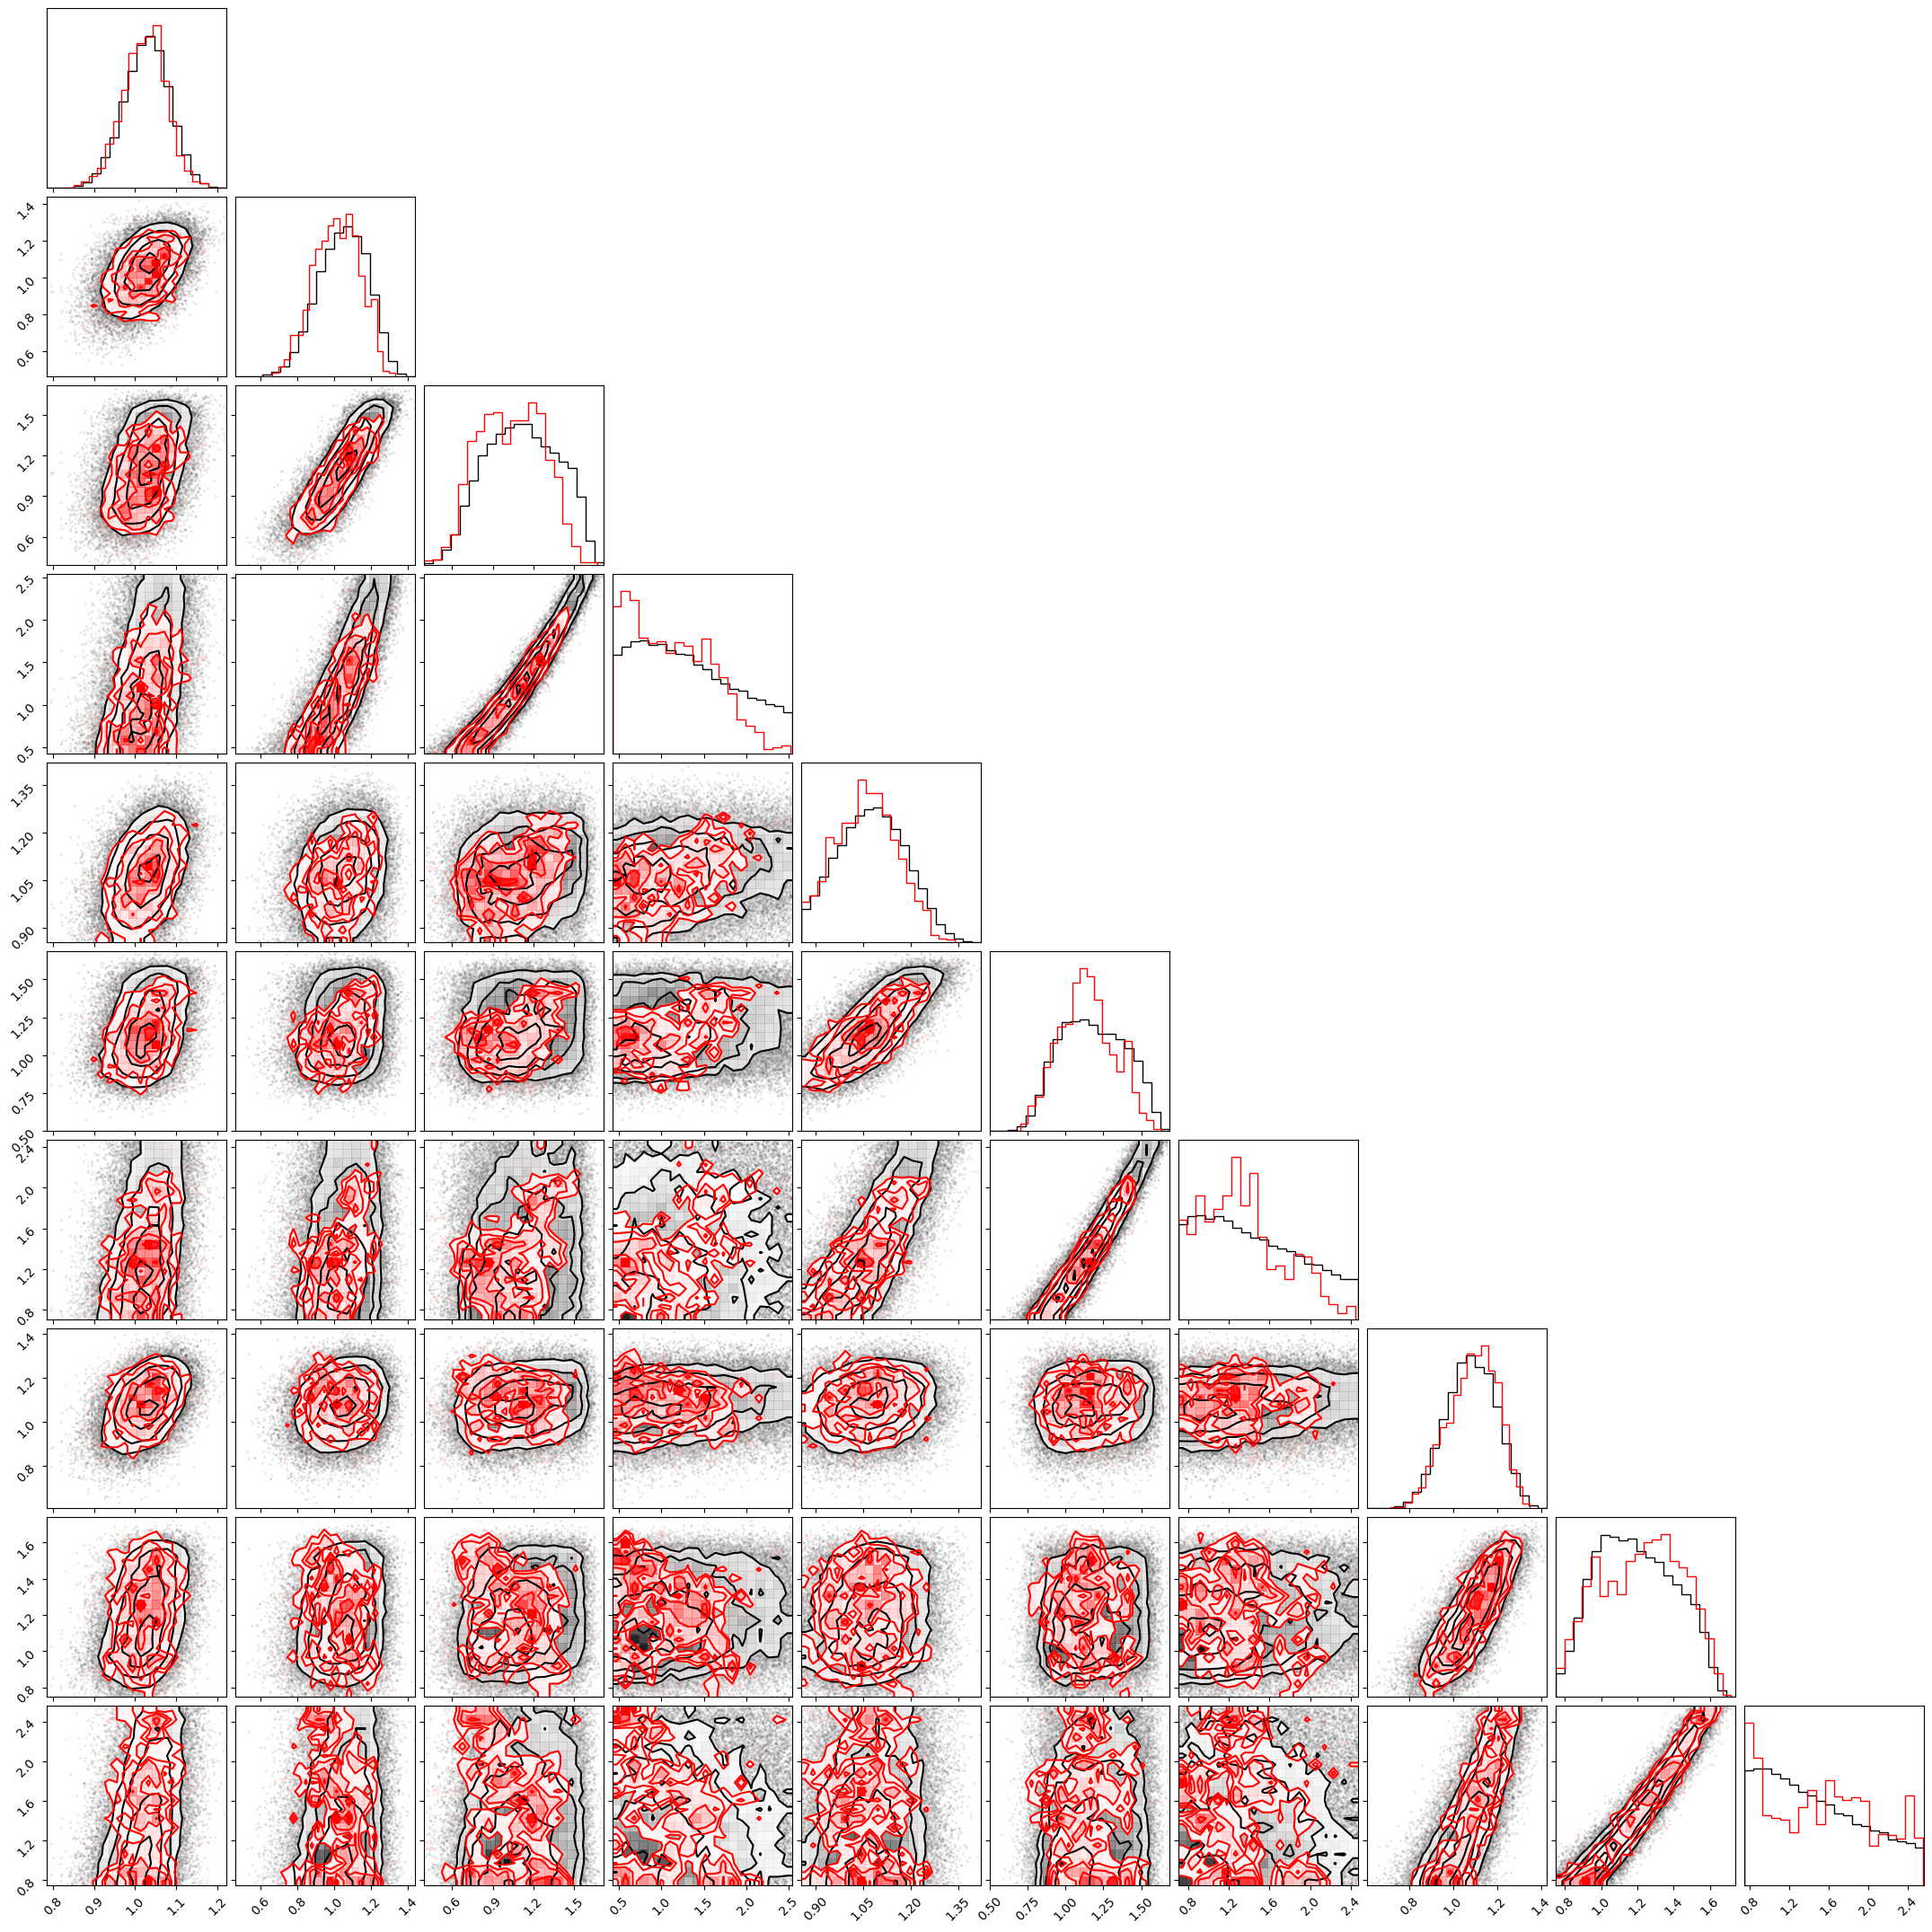

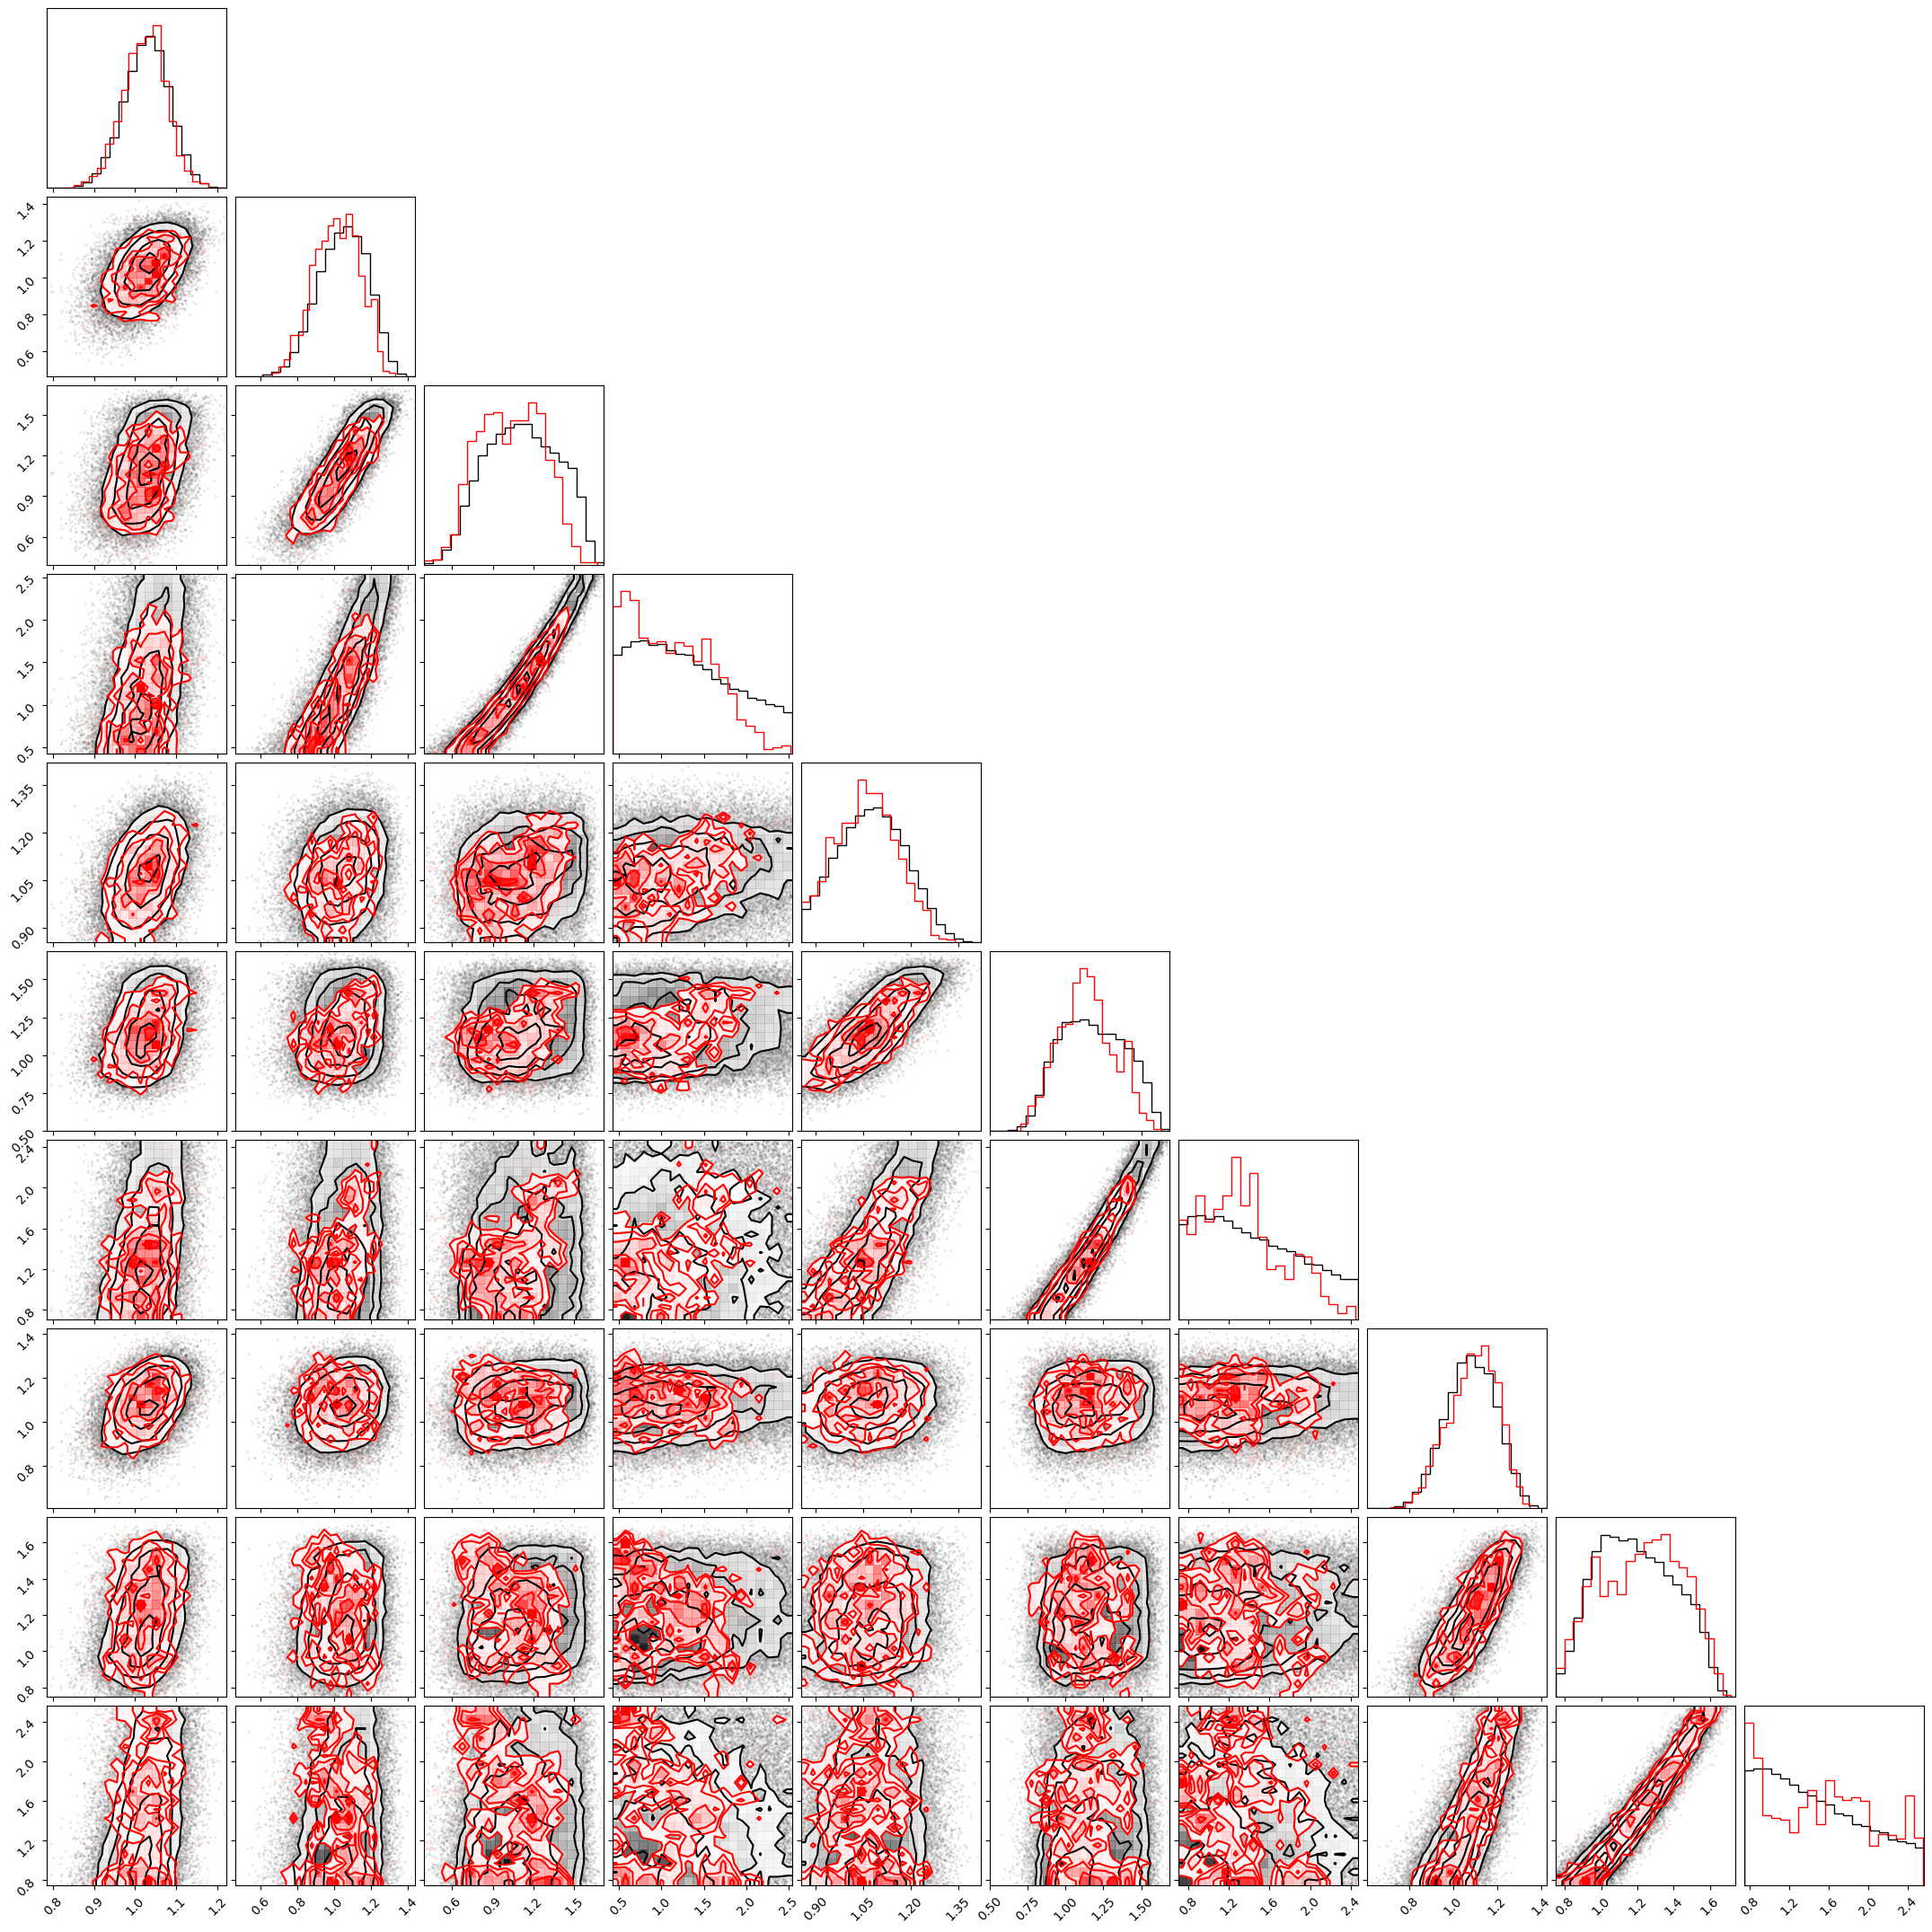

In [19]:
samples_jaxns = np.array(resample(random.PRNGKey(42), results.samples, results.log_dp_mean, S=int(results.ESS))['x'])
print('Number of samples obtained: %i' % samples_jaxns.shape[0])
fig1 = corner(bounded_iid_samples[0:30000], hist_kwargs={'density':True})
corner(np.array(samples_jaxns), color='r', fig=fig1, hist_kwargs={'density':True})

In [13]:
resample(random.PRNGKey(42), results.samples, results.log_dp_mean, S=int(results.ESS))['x'].shape

(1908, 10)